In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import os.path
from scipy.optimize import curve_fit
from scipy import interpolate
import math
import os 
from tqdm import tqdm_notebook as tqdm
from scipy.stats import chisquare
import re
from datetime import datetime
import scipy.stats as stats
import time
from scipy.stats.stats import pearsonr
PI=math.pi

## Построение графика распределения


Сигмы
4.0963218765363045
9.667412117443893

Среднее
Средний угол прихода ливня 17.291372, погрешность 12.867606, установка
Средний угол прихода ливня 17.158393, погрешность 15.713005, кластер
Средний угол прихода ливня 17.327280, погрешность 12.070815, реально


Text(0.5,1,'График для числа разностей реальных и пересчитанных углов для кластера')

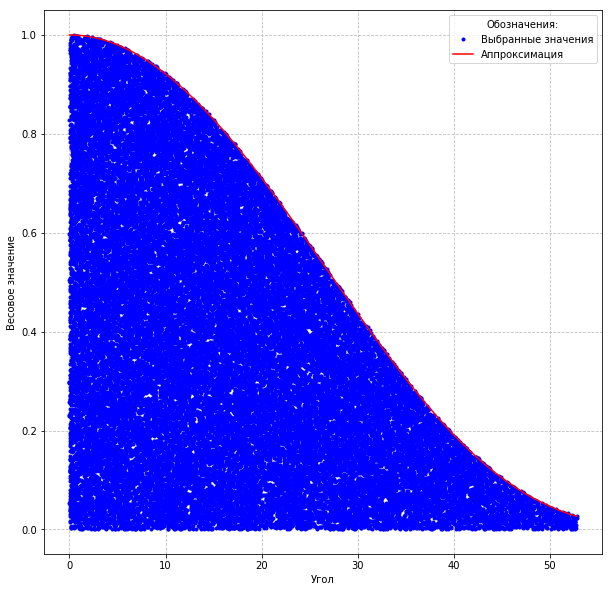

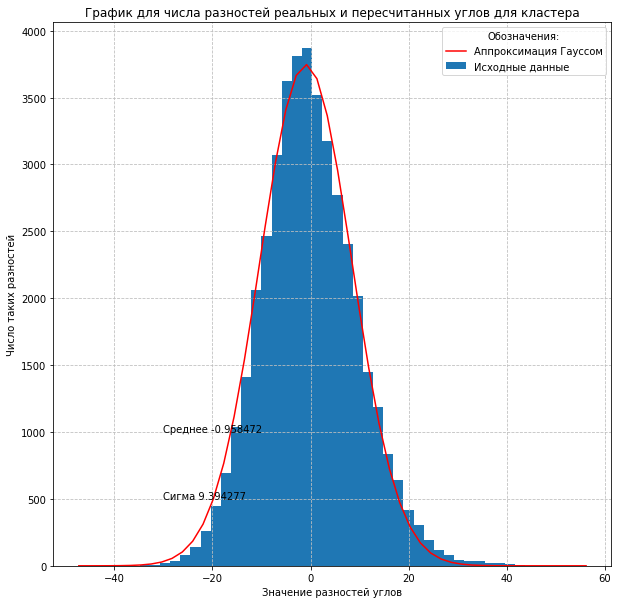

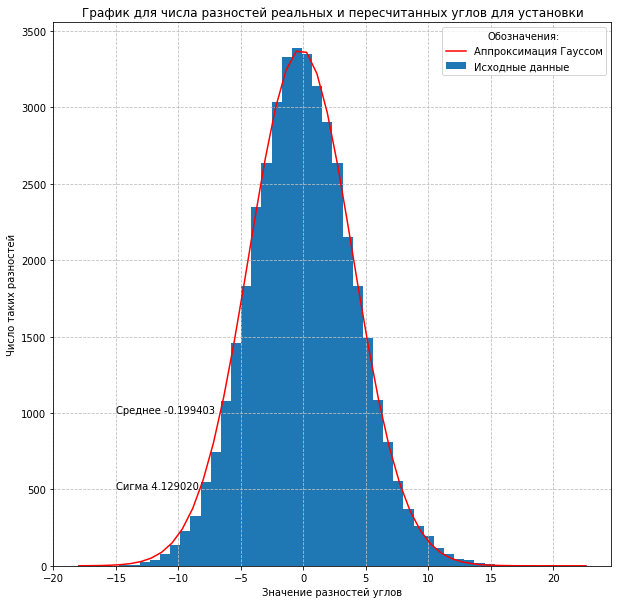

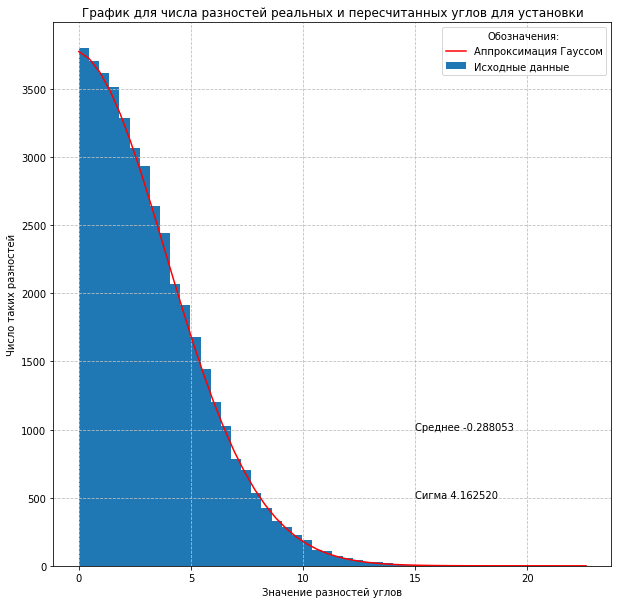

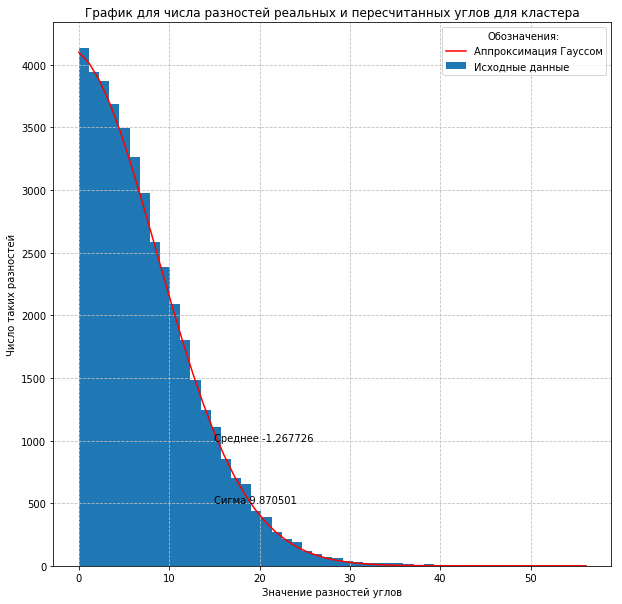

In [6]:
# Диапазон углов градусы
maxAn = 55/180*math.pi

# Заполнение массива значениями их диапазона углов
graph = np.array([float(maxAn*i/80000) for i in range (0,80001,1)])

# Рассчет значений функции распределения
y = np.array([  math.exp(-4.88*(1/math.cos(graph[i])-1)) for i in range (0,80001,1) ])
x = np.array([i for i in range (0,80001,1)])

# в х0 сидят значения углов, в игрек0 - значения из распределения углов на высоте
x0 = np.array([float(i*maxAn/80000) for i in range (0,80001,1)]) 
y0 = np.array([(np.random.sample()*(1.0 - math.exp(-4.88*1.5)) + math.exp(-4.88*1.5)) for i in range(0,80001,1)])

j = 0
teta = pd.DataFrame()

for i in tqdm(range (0,80001,1)):
    if ( y0[i] < math.exp( -4.88 * ( 1 / math.cos(x0[i])-1 ) ) ): 
        teta.loc[j,0] = x0[i]
        teta.loc[j,1] = y0[i]
        j = j + 1

# Вплоскости 4 детекторов выбираются координаты оси ливня
timesiter = len(teta)
phi = np.array([float(i/180*math.pi) for i in range(0,360,1)])  
radius = np.array([i*6/2**(1/2)/timesiter for i in range(0,timesiter-1,1)])

# Получение столбцов времен прихода и соответствующих углов 
maxsigma13 = pd.DataFrame()
mu, sigma = 0, 13.742/2 

for j in tqdm(range(0,(timesiter-1),1)):
    
    maxsigma13.loc[j,'small'] = 3 * 15 * math.sin(teta.loc[j,0])
    maxsigma13.loc[j,'big'  ] = 3 * 35 * math.sin(teta.loc[j,0])
    maxsigma13.loc[j,'anglereal'] = teta.loc[j,0]
    
    a = np.random.normal(mu, sigma, 1)
    if ((a + maxsigma13.loc[j,'small']) < 0):
        maxsigma13.loc[j,'mixedS'] = math.fabs(a) + maxsigma13.loc[j,'small']
    elif ((a + maxsigma13.loc[j,'small']) > math.pi/2): 
        maxsigma13.loc[j,'mixedS'] = -a + maxsigma13.loc[j,'small']
    else: maxsigma13.loc[j,'mixedS'] = a + maxsigma13.loc[j,'small']
      
    a = np.random.normal(mu, sigma, 1)
    if ((a + maxsigma13.loc[j,'big']) < 0):
        maxsigma13.loc[j,'mixedB'] = math.fabs(a) + maxsigma13.loc[j,'big']
    elif ((a + maxsigma13.loc[j,'big']) > math.pi/2): 
        maxsigma13.loc[j,'mixedB'] = -a + maxsigma13.loc[j,'big']
    else: maxsigma13.loc[j,'mixedB'] = a + maxsigma13.loc[j,'big']    

    if ( math.fabs(maxsigma13.loc[j,'mixedB']) < 105 ):
        maxsigma13.loc[j,'angleB'] = math.asin(maxsigma13.loc[j,'mixedB']/(3*35))
        
    if ( math.fabs(maxsigma13.loc[j,'mixedS']) < 45 ):
        maxsigma13.loc[j,'angleS'] = math.asin(maxsigma13.loc[j,'mixedS']/(3*15))
        
maxsigma13 = maxsigma13.dropna(axis = 0)

razrBB =57* np.sqrt(np.sum((maxsigma13['angleB'] - maxsigma13['anglereal'])**2 ) /maxsigma13.shape[0])   
razrSS =57* np.sqrt(np.sum((maxsigma13['angleS'] - maxsigma13['anglereal'])**2 ) /maxsigma13.shape[0])   
meanB = 57*maxsigma13['angleB'].mean()
meanS = 57*maxsigma13['angleS'].mean()
meanR = 57*maxsigma13['anglereal'].mean()
sigmaB = 57* np.sqrt(np.sum((maxsigma13['angleB'] - meanB/57)**2 ) /maxsigma13.shape[0])
sigmaS = 57* np.sqrt(np.sum((maxsigma13['angleS'] - meanS/57)**2 ) /maxsigma13.shape[0])
sigmaR = 57* np.sqrt(np.sum((maxsigma13['anglereal'] - meanR/57)**2 ) /maxsigma13.shape[0])
print('Сигмы')
print(razrBB) 
print(razrSS)     
print()
print('Среднее')
print('Средний угол прихода ливня %f, погрешность %f, установка' %(meanB, sigmaB))

print('Средний угол прихода ливня %f, погрешность %f, кластер' %(meanS, sigmaS))

print('Средний угол прихода ливня %f, погрешность %f, реально' %(meanR, sigmaR))

    
plt.figure(figsize = (10,10))  
plt.plot(teta[0]*55,teta[1],'b.', label = 'Выбранные значения')
plt.plot(x0*55,y, 'r-', label = 'Аппроксимация' )
plt.grid(True, linestyle='--', color='0.75')
plt.xlabel('Угол')
plt.ylabel('Весовое значение')
plt.legend(title = 'Обозначения:')

def func_gauss(x, sigm, mu, A):
    return np.exp(-((x-mu)**2)/(2*sigm**2))*A

plt.figure(figsize = (10,10)) 

xdata=np.linspace(57*(maxsigma13['angleS']-maxsigma13['anglereal']).min(), 
                  57*(maxsigma13['angleS']-maxsigma13['anglereal']).max(), 
                  num=50)
ydata=((maxsigma13['angleS']-maxsigma13['anglereal']).value_counts(normalize=False, sort=False, ascending = True, bins=50, dropna=False))
popt, pcov = curve_fit(func_gauss,xdata, ydata)#, p0=[0, 10,800], method = 'lm')
plt.hist(57*(maxsigma13['angleS']-maxsigma13['anglereal']), bins = 50, label = 'Исходные данные')
plt.plot(xdata, func_gauss(xdata, *popt), 'r-', label=u'Аппроксимация Гауссом')
plt.text(-30, 500, 'Сигма %f' %(math.fabs(popt[0])))
plt.text(-30, 1000, 'Среднее %f' %(popt[1]))
plt.grid(True, linestyle='--', color='0.75')
plt.legend(title = 'Обозначения:')
plt.ylabel('Число таких разностей')
plt.xlabel('Значение разностей углов')
plt.title('График для числа разностей реальных и пересчитанных углов для кластера')

plt.figure(figsize = (10,10)) 

xdata=np.linspace(57*(maxsigma13['angleB']-maxsigma13['anglereal']).min(), 
                  57*(maxsigma13['angleB']-maxsigma13['anglereal']).max(), 
                  num=50)
ydata=((maxsigma13['angleB']-maxsigma13['anglereal']).value_counts(normalize=False, sort=False, ascending = True, bins=50, dropna=False))
popt, pcov = curve_fit(func_gauss,xdata, ydata)#, p0=[0, 10,800], method = 'lm')
plt.hist(57*(maxsigma13['angleB']-maxsigma13['anglereal']), bins = 50, label = 'Исходные данные')
plt.plot(xdata, func_gauss(xdata, *popt), 'r-', label=u'Аппроксимация Гауссом')
plt.text(-15, 500, 'Сигма %f' %(math.fabs(popt[0])))
plt.text(-15, 1000, 'Среднее %f' %(popt[1]))
plt.grid(True, linestyle='--', color='0.75')
plt.legend(title = 'Обозначения:')
plt.ylabel('Число таких разностей')
plt.xlabel('Значение разностей углов')
plt.title('График для числа разностей реальных и пересчитанных углов для установки')


plt.figure(figsize = (10,10)) 
maxsigma13['abs_delta_angle'] = np.abs(maxsigma13['angleB']-maxsigma13['anglereal'])
xdata=np.linspace(57*maxsigma13['abs_delta_angle'].min(), 
                  57*maxsigma13['abs_delta_angle'].max(), 
                  num=50)
ydata=(maxsigma13['abs_delta_angle'].value_counts(normalize=False, sort=False, ascending = True, bins=50, dropna=False))
popt, pcov = curve_fit(func_gauss,xdata, ydata)#, p0=[0, 10,800], method = 'lm')
plt.hist(57*maxsigma13['abs_delta_angle'], bins = 50, label = 'Исходные данные')
plt.plot(xdata, func_gauss(xdata, *popt), 'r-', label=u'Аппроксимация Гауссом')
plt.text(15, 500, 'Сигма %f' %(math.fabs(popt[0])))
plt.text(15, 1000, 'Среднее %f' %(popt[1]))
plt.grid(True, linestyle='--', color='0.75')
plt.legend(title = 'Обозначения:')
plt.ylabel('Число таких разностей')
plt.xlabel('Значение разностей углов')
plt.title('График для числа разностей реальных и пересчитанных углов для установки')


plt.figure(figsize = (10,10)) 
maxsigma13['abs_delta_angle'] = np.abs(maxsigma13['angleS']-maxsigma13['anglereal'])
xdata=np.linspace(57*maxsigma13['abs_delta_angle'].min(), 
                  57*maxsigma13['abs_delta_angle'].max(), 
                  num=50)
ydata=(maxsigma13['abs_delta_angle'].value_counts(normalize=False, sort=False, ascending = True, bins=50, dropna=False))
popt, pcov = curve_fit(func_gauss,xdata, ydata)#, p0=[0, 10,800], method = 'lm')
plt.hist(57*maxsigma13['abs_delta_angle'], bins = 50, label = 'Исходные данные')
plt.plot(xdata, func_gauss(xdata, *popt), 'r-', label=u'Аппроксимация Гауссом')
plt.text(15, 500, 'Сигма %f' %(math.fabs(popt[0])))
plt.text(15, 1000, 'Среднее %f' %(popt[1]))
plt.grid(True, linestyle='--', color='0.75')
plt.legend(title = 'Обозначения:')
plt.ylabel('Число таких разностей')
plt.xlabel('Значение разностей углов')
plt.title('График для числа разностей реальных и пересчитанных углов для кластера')

In [31]:
print(57*kriticalS)
print(57*kriticalB)

8.73744430474538
3.7326386173411454


Text(0.5,1,'График для числа разностей реальных и пересчитанных углов для кластера')

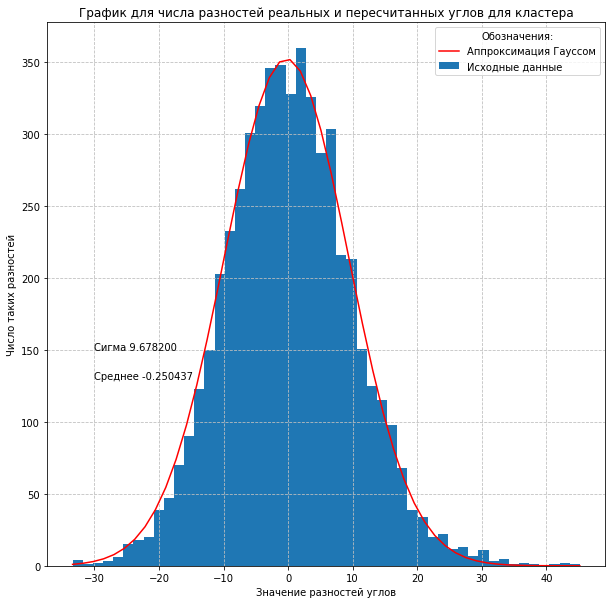

In [16]:
def func_gauss(x, sigm, mu, A):
    return np.exp(-((x-mu)**2)/(2*sigm**2))*A

plt.figure(figsize = (10,10)) 

xdata=np.linspace(57*(maxsigma13['angleS']-maxsigma13['anglereal']).min(), 
                  57*(maxsigma13['angleS']-maxsigma13['anglereal']).max(), 
                  num=50)
ydata=((maxsigma13['angleS']-maxsigma13['anglereal']).value_counts(normalize=False, sort=False, ascending = True, bins=50, dropna=False))
popt, pcov = curve_fit(func_gauss,xdata, ydata)#, p0=[0, 10,800], method = 'lm')
plt.hist(57*(maxsigma13['angleS']-maxsigma13['anglereal']), bins = 50, label = 'Исходные данные')
plt.plot(xdata, func_gauss(xdata, *popt), 'r-', label=u'Аппроксимация Гауссом')
plt.text(-30, 150, 'Сигма %f' %(math.fabs(popt[0])))
plt.text(-30, 130, 'Среднее %f' %(popt[1]))
plt.grid(True, linestyle='--', color='0.75')
plt.legend(title = 'Обозначения:')
plt.ylabel('Число таких разностей')
plt.xlabel('Значение разностей углов')
plt.title('График для числа разностей реальных и пересчитанных углов для кластера')

Text(0.5,1,'График для числа разностей реальных и пересчитанных углов для кластера')

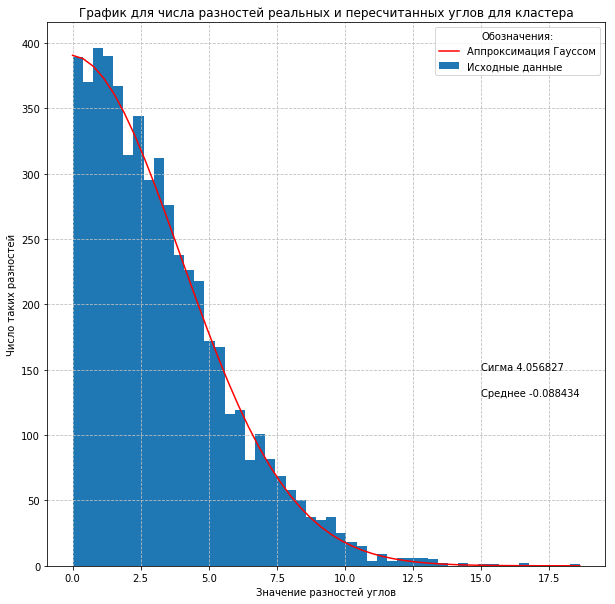

In [24]:
def func_gauss(x, sigm, mu, A):
    return np.exp(-((x-mu)**2)/(2*sigm**2))*A

plt.figure(figsize = (10,10)) 
maxsigma13['abs_delta_angle'] = np.abs(maxsigma13['angleB']-maxsigma13['anglereal'])
xdata=np.linspace(57*maxsigma13['abs_delta_angle'].min(), 
                  57*maxsigma13['abs_delta_angle'].max(), 
                  num=50)
ydata=(maxsigma13['abs_delta_angle'].value_counts(normalize=False, sort=False, ascending = True, bins=50, dropna=False))
popt, pcov = curve_fit(func_gauss,xdata, ydata)#, p0=[0, 10,800], method = 'lm')
plt.hist(57*maxsigma13['abs_delta_angle'], bins = 50, label = 'Исходные данные')
plt.plot(xdata, func_gauss(xdata, *popt), 'r-', label=u'Аппроксимация Гауссом')
plt.text(15, 150, 'Сигма %f' %(math.fabs(popt[0])))
plt.text(15, 130, 'Среднее %f' %(popt[1]))
plt.grid(True, linestyle='--', color='0.75')
plt.legend(title = 'Обозначения:')
plt.ylabel('Число таких разностей')
plt.xlabel('Значение разностей углов')
plt.title('График для числа разностей реальных и пересчитанных углов для кластера')

Text(0.5,1,'График для числа разностей реальных и пересчитанных углов для установки')

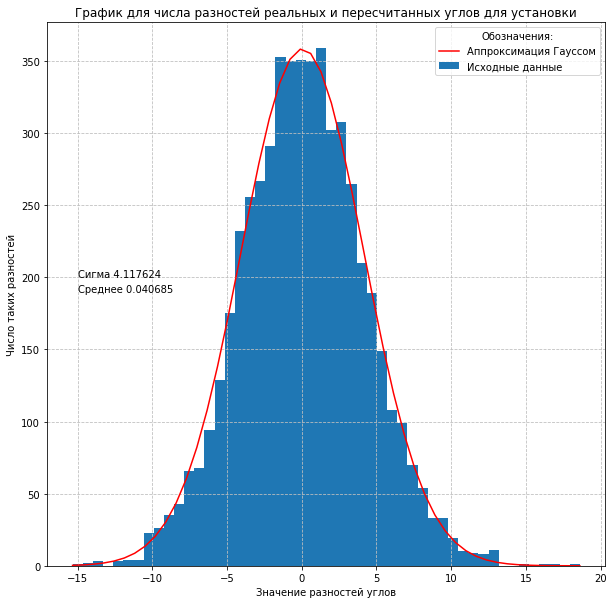

In [17]:
def func_gauss(x, sigm, mu, A):
    return np.exp(-((x-mu)**2)/(2*sigm**2))*A

plt.figure(figsize = (10,10)) 

xdata=np.linspace(57*(maxsigma13['angleB']-maxsigma13['anglereal']).min(), 
                  57*(maxsigma13['angleB']-maxsigma13['anglereal']).max(), 
                  num=50)
ydata=((maxsigma13['angleB']-maxsigma13['anglereal']).value_counts(normalize=False, sort=False, ascending = True, bins=50, dropna=False))
popt, pcov = curve_fit(func_gauss,xdata, ydata)#, p0=[0, 10,800], method = 'lm')
plt.hist(57*(maxsigma13['angleB']-maxsigma13['anglereal']), bins = 50, label = 'Исходные данные')
plt.plot(xdata, func_gauss(xdata, *popt), 'r-', label=u'Аппроксимация Гауссом')
plt.text(-15, 200, 'Сигма %f' %(math.fabs(popt[0])))
plt.text(-15, 190, 'Среднее %f' %(popt[1]))
plt.grid(True, linestyle='--', color='0.75')
plt.legend(title = 'Обозначения:')
plt.ylabel('Число таких разностей')
plt.xlabel('Значение разностей углов')
plt.title('График для числа разностей реальных и пересчитанных углов для установки')